In [1]:
import scipy.interpolate
import teqp
teqp.__version__

'0.18.0'

# Critical curves & points


## Pure Fluids

Solving for the critical point involves finding the temperature and density that make
$$
\left(\frac{\partial p}{\partial \rho}\right)_T = \left(\frac{\partial^2 p}{\partial \rho^2}\right)_T = 0
$$
by 2D non-linear rootfinding. Newton steps are taken, and the analytic Jacobian is used (thanks to the ability to do derivatives with automatic differentiation).  This is all handily wrapped up in the
``solve_pure_critical`` method which requires the user to provide guess values for temperature and density

In [2]:
# Values taken from http://dx.doi.org/10.6028/jres.121.011
modelPR = teqp.canonical_PR([190.564], [4599200], [0.011])

# Solve for the critical point from a point close to the critical point
T0 = 192.0
# Critical compressibility factor of P-R is 0.307401308698.. (see https://doi.org/10.1021/acs.iecr.1c00847)
rhoc = (4599200/(8.31446261815324*190.564))/0.3074
rho0 = rhoc*1.2345 # Perturb to make sure we are doing something in the solver
modelPR.solve_pure_critical(T0, rho0)

(190.564, 9442.816240022832)

If you have a mixture, but want to obtain the critical point of a pure fluid of this mixture, you can specify the index of the component in the mixture, as well as the number of componnts in the mixture with something like:

``
model.solve_pure_critical(T0, rho0, {"alternative_pure_index": 1, "alternative_length": 2})
``
so here, for the second fluid, with 0-based index of 1, in a two-component mixture

## Mixtures

A pure fluid has a single vapor-liquid critical point, but mixtures are different:

* They may have multiple (or zero!) critical points for a given mixture composition
* The critical curves may not emanate from the pure fluid endpoints

When it comes to critical points, intuition from pure fluids is not helpful, or sometimes even counter-productive. 

teqp has methods for working with the critical loci of binary mixtures (only binary mixtures, for now) and especially, methods for tracing the critical curves emanating from the pure fluid endpoints.

The tracing method in teqp is based explicitly on the isochoric thermodynamics formalism introduced by Ulrich Deiters and Sergio Quinones-Cisneros.  It uses the Helmholtz energy density as the fundamental potential and all other properties are derived from it.  For critical curves it is based upon the integration of sets of ordinary differential equations; the differential equations are in the form of derivatives of the molar concentrations of each component in the mixture with respect to an integration variable.  The set of ODE is then integrated.

Here is an example of the construction of the critical curves emanating from the pure fluid endpoints for the mixture nitrogen + ethane.

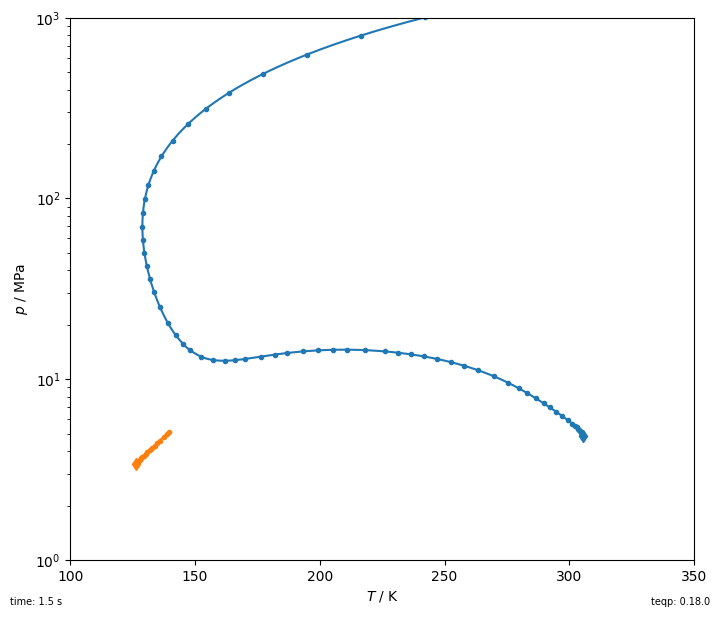

In [3]:
import timeit
import numpy as np
import matplotlib.pyplot as plt 
import pandas
import teqp

def get_critical_curve(ipure):
    """ Return curve as pandas DataFrame """
    names = ['Nitrogen', 'Ethane']
    model = teqp.build_multifluid_model(names, teqp.get_datapath())
    T0 = model.get_Tcvec()[ipure]
    rho0 = np.array([1.0/model.get_vcvec()[ipure]]*2)
    rho0[1-ipure] = 0
    o = teqp.TCABOptions() 
    o.init_dt = 1.0 # step in the arclength tracing parameter
    o.rel_err = 1e-8
    o.abs_err = 1e-5
    o.integration_order = 5
    o.calc_stability = True
    o.polish = True
    curveJSON = model.trace_critical_arclength_binary(T0, rho0, '', o)
    df = pandas.DataFrame(curveJSON)
    rhotot = df['rho0 / mol/m^3']+df['rho1 / mol/m^3']
    df['z0 / mole frac.'] = df['rho0 / mol/m^3']/rhotot
    return df

fig, ax = plt.subplots(1,1,figsize=(7, 6))
tic = timeit.default_timer()
for ipure in [1,0]:
    df = get_critical_curve(ipure)
    first_unstable = np.argmax(~df['locally stable'])
    df = df.iloc[0:(first_unstable if first_unstable else len(df))]
    line, = plt.plot(df['T / K'], df['p / Pa']/1e6, '.')
    
    # And interpolate to smooth out the curve using the arclength
    # parameter (which must be monotonically increasing) as 
    # the interpolation variable
    tinterp = np.linspace(df['t'].min(), df['t'].max(), 10000)
    Tinterp = scipy.interpolate.interp1d(df['t'], df['T / K'], kind='cubic')(tinterp)
    pinterp = scipy.interpolate.interp1d(df['t'], df['p / Pa'], kind='cubic')(tinterp)
    plt.plot(Tinterp, pinterp/1e6, color=line.get_color())
    
    plt.plot(df['T / K'].iloc[0], df['p / Pa'].iloc[0]/1e6, 'd', 
        color=line.get_color())

elap = timeit.default_timer()-tic
plt.gca().set(xlabel='$T$ / K', ylabel='$p$ / MPa',
    xlim=(100, 350), ylim=(1, 1e3))
plt.yscale('log')
plt.tight_layout(pad=0.2)
plt.gcf().text(0,0,f'time: {elap:0.1f} s', ha='left', va='bottom', fontsize=7)
plt.gcf().text(1,0,f'teqp: {teqp.__version__}', ha='right', va='bottom', fontsize=7);

And now for something a bit more interesting: ethane + alkane critical curves

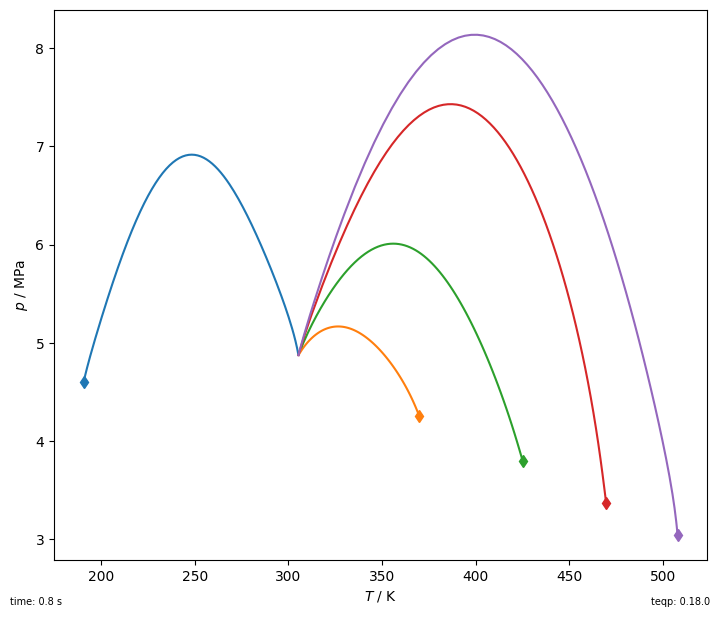

In [4]:
import timeit
import numpy as np
import matplotlib.pyplot as plt 
import pandas
import teqp

def get_critical_curve(names, ipure):
    """ Return curve as pandas DataFrame """
    model = teqp.build_multifluid_model(names, teqp.get_datapath())
    T0 = model.get_Tcvec()[ipure]
    rho0 = np.array([1.0/model.get_vcvec()[ipure]]*2)
    rho0[1-ipure] = 0
    o = teqp.TCABOptions() 
#     print(dir(o))
    o.init_dt = 1.0 # step in the parameter
    o.rel_err = 1e-6 # relative error on the step
    o.abs_err = 1e-6 # absolute error on the step
    o.max_dt = 100 # cap the size of the allowed step
    o.calc_stability = True
    o.polish = True
    curveJSON = model.trace_critical_arclength_binary(T0, rho0, '', o)
    df = pandas.DataFrame(curveJSON)
    rhotot = df['rho0 / mol/m^3']+df['rho1 / mol/m^3']
    df['z0 / mole frac.'] = df['rho0 / mol/m^3']/rhotot
    return df

fig, ax = plt.subplots(1,1,figsize=(7, 6))
tic = timeit.default_timer()
name0 = 'ETHANE'
for othername in ['METHANE','PROPANE','BUTANE','PENTANE','HEXANE']:
    for ipure in [1]:
        df = get_critical_curve([name0, othername], ipure)
        line, = plt.plot(df['T / K'], df['p / Pa']/1e6, '-')
        plt.plot(df['T / K'].iloc[0], df['p / Pa'].iloc[0]/1e6, 'd', 
            color=line.get_color())

elap = timeit.default_timer()-tic
plt.gca().set(xlabel='$T$ / K', ylabel='$p$ / MPa')#,xlim=(100, 350), ylim=(1, 1e3))
plt.tight_layout(pad=0.2)
plt.gcf().text(0,0,f'time: {elap:0.1f} s', ha='left', va='bottom', fontsize=7)
plt.gcf().text(1,0,f'teqp: {teqp.__version__}', ha='right', va='bottom', fontsize=7);